# [Direct Preference Optimization: Your Language Model is Secretly a Reward Model (DPO)](https://arxiv.org/pdf/2305.18290.pdf)

### Reference Code
- https://huggingface.co/docs/trl/main/en/dpo_trainer
- https://github.com/huggingface/trl/blob/main/examples/scripts/dpo.py

Therefore the final dataset object should contain these 3 entries if you use the default DPODataCollatorWithPadding data collator.

The entries should be named:
- prompt
- chosen
- rejected

In [7]:
!pip install datasets
!pip install trl

  Using cached trl-0.15.2-py3-none-any.whl.metadata (11 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-manylinux2

In [8]:
import os
import torch
# Set GPU device
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# os.environ['http_proxy']  = 'http://192.41.170.23:3128'
# os.environ['https_proxy'] = 'http://192.41.170.23:3128'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [9]:
dpo_dataset_dict = {
    "prompt": [
        "hello",
        "how are you",
        "What is your name?",
        "What is your name?",
        "Which is the best programming language?",
        "Which is the best programming language?",
        "Which is the best programming language?",
    ],
    "chosen": [
        "hi nice to meet you",
        "I am fine",
        "My name is Mary",
        "My name is Mary",
        "Python",
        "Python",
        "Java",
    ],
    "rejected": [
        "leave me alone",
        "I am not fine",
        "Whats it to you?",
        "I dont have a name",
        "Javascript",
        "C++",
        "C++",
    ],
}

In [10]:
import torch
from datasets import Dataset, load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    HfArgumentParser,
    TrainingArguments
)

from typing import Dict, Optional
from trl import DPOTrainer, DPOConfig

# 1. load a pretrained model and tokenizer

In [11]:
model_name_or_path = "gpt2"
ignore_bias_buffers = False

model = AutoModelForCausalLM.from_pretrained(model_name_or_path)
if ignore_bias_buffers:
    # torch distributed hack
    model._ddp_params_and_buffers_to_ignore = [
        name for name, buffer in model.named_buffers() if buffer.dtype == torch.bool
    ]

model_ref = AutoModelForCausalLM.from_pretrained(model_name_or_path)
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

The DPO trainer expects a model of AutoModelForCausalLM, compared to PPO that expects AutoModelForCausalLMWithValueHead for the value function.

## 2. Load the Anthropic Helpful-Harmless dataset

In [12]:
def extract_anthropic_prompt(prompt_and_response):
    """Extract the anthropic prompt from a prompt and response pair."""
    search_term = "\n\nAssistant:"
    search_term_idx = prompt_and_response.rfind(search_term)
    assert search_term_idx != -1, f"Prompt and response does not contain '{search_term}'"
    return prompt_and_response[: search_term_idx + len(search_term)]

def get_hh(split: str, sanity_check: bool = False, silent: bool = False, cache_dir: str = None) -> Dataset:
    """Load the Anthropic Helpful-Harmless dataset from Hugging Face and convert it to the necessary format.

    The dataset is converted to a dictionary with the following structure:
    {
        'prompt': List[str],
        'chosen': List[str],
        'rejected': List[str],
    }

    Prompts should be structured as follows:
      \n\nHuman: <prompt>\n\nAssistant:
    Multiple turns are allowed, but the prompt should always start with \n\nHuman: and end with \n\nAssistant:.
    """

    dataset = load_dataset("Anthropic/hh-rlhf", split=split, cache_dir=cache_dir)
    if sanity_check:
        dataset = dataset.select(range(min(len(dataset), 10))) # 10 as small subset for quick experiments

    def split_prompt_and_responses(sample) -> Dict[str, str]:
        prompt = extract_anthropic_prompt(sample["chosen"])
        return {
            "prompt": prompt,
            "chosen": sample["chosen"][len(prompt) :],
            "rejected": sample["rejected"][len(prompt) :],
        }

    return dataset.map(split_prompt_and_responses)

In [15]:
sanity_check = True
train_dataset = get_hh("train", sanity_check=sanity_check)
eval_dataset = get_hh("test", sanity_check=sanity_check)

README.md:   0%|          | 0.00/5.77k [00:00<?, ?B/s]

train.jsonl.gz:   0%|          | 0.00/13.2M [00:00<?, ?B/s]

train.jsonl.gz:   0%|          | 0.00/16.2M [00:00<?, ?B/s]

train.jsonl.gz:   0%|          | 0.00/20.1M [00:00<?, ?B/s]

train.jsonl.gz:   0%|          | 0.00/25.7M [00:00<?, ?B/s]

test.jsonl.gz:   0%|          | 0.00/743k [00:00<?, ?B/s]

test.jsonl.gz:   0%|          | 0.00/875k [00:00<?, ?B/s]

test.jsonl.gz:   0%|          | 0.00/1.05M [00:00<?, ?B/s]

test.jsonl.gz:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/160800 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/8552 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

In [16]:
train_dataset

Dataset({
    features: ['chosen', 'rejected', 'prompt'],
    num_rows: 10
})

In [17]:
eval_dataset

Dataset({
    features: ['chosen', 'rejected', 'prompt'],
    num_rows: 10
})

# 3. Initialize training arguments:

In [19]:
hyperparams = [
    {"per_device_train_batch_size": 8, "learning_rate": 1e-3, "gradient_accumulation_steps": 1, "max_steps": 1000},  # Baseline setting
    {"per_device_train_batch_size": 8, "learning_rate": 5e-4, "gradient_accumulation_steps": 1, "max_steps": 1000},  # Lower LR
    {"per_device_train_batch_size": 4, "learning_rate": 1e-3, "gradient_accumulation_steps": 4, "max_steps": 1000},  # Smaller batch + accumulation
    {"per_device_train_batch_size": 8, "learning_rate": 1e-4, "gradient_accumulation_steps": 4, "max_steps": 1000},  # Lower LR + accumulation
    {"per_device_train_batch_size": 8, "learning_rate": 5e-4, "gradient_accumulation_steps": 4, "max_steps": 2000},  # More training steps
]


max_length= 512
max_prompt_length = 128
max_target_length =128
label_pad_token_id = 100
# instrumentation
sanity_check = True
report_to = None
gradient_checkpointing = None
beta = 0.1

In [20]:
# learning_rate = 1e-3
# per_device_train_batch_size = 8 # reduced from 8 to 1
# gradient_accumulation_steps = 1 # changed from 1 to 4
# max_length= 512
# max_prompt_length = 128
# max_target_length =128
# label_pad_token_id = 100
# max_steps = 1000
# # instrumentation
# sanity_check = True
# report_to = None
# gradient_checkpointing = None # changed from None to True
# beta = 0.1

In [21]:
# training_args = DPOConfig(
#     per_device_train_batch_size=per_device_train_batch_size,
#     max_steps=max_steps,
#     remove_unused_columns=False,
#     gradient_accumulation_steps=gradient_accumulation_steps,
#     learning_rate=learning_rate,
#     evaluation_strategy="steps",
#     logging_first_step=True,
#     logging_steps=5,  # match results in blog post
#     eval_steps=1000, # change from 500 to 1000
#     output_dir="./test",
#     optim="rmsprop",
#     warmup_steps=150,
#     report_to=report_to,
#     bf16=True, # change from True to False
#     gradient_checkpointing=gradient_checkpointing,
#     # TODO: uncomment that on the next transformers release
#     # gradient_checkpointing_kwargs=gradient_checkpointing_kwargs,
# )

# 4. initialize  and train the DPO trainer

In [26]:
best_loss = float("inf")  # Initialize with a high value
best_hyperparams = None

In [27]:
results = []

for params in hyperparams:
    print(f"\nTraining with batch_size={params['per_device_train_batch_size']}, lr={params['learning_rate']}, grad_accum={params['gradient_accumulation_steps']}, max_steps={params['max_steps']}\n")

    training_args = DPOConfig(
        per_device_train_batch_size=params["per_device_train_batch_size"],
        max_steps=params["max_steps"],
        remove_unused_columns=False,
        gradient_accumulation_steps=params["gradient_accumulation_steps"],
        learning_rate=params["learning_rate"],
        evaluation_strategy="steps",
        logging_first_step=True,
        logging_steps=5, # match results in blog post
        eval_steps=500,
        output_dir="./test",
        optim="rmsprop",
        warmup_steps=150,
        report_to=report_to,
        bf16=True,
        gradient_checkpointing=gradient_checkpointing
        # TODO: uncomment that on the next transformers release
        # gradient_checkpointing_kwargs=gradient_checkpointing_kwargs,
    )

    dpo_trainer = DPOTrainer(
        model=model,
        ref_model=model_ref,
        args=training_args,
        tokenizer=tokenizer,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset
    )

    train_output = dpo_trainer.train()

    # Get final loss value
    final_loss = dpo_trainer.state.log_history[-1]["loss"] if "loss" in dpo_trainer.state.log_history[-1] else float("inf")

    results.append({
        "per_device_train_batch_size": params["per_device_train_batch_size"],
        "learning_rate": params["learning_rate"],
        "gradient_accumulation_steps": params["gradient_accumulation_steps"],
        "final_loss": final_loss,
        "train_loss": dpo_trainer.state.log_history
    })

    # Store the model with the lowest loss
    if final_loss < best_loss:
        best_loss = final_loss
        best_hyperparams = params  # Store hyperparameters of best model


Training with batch_size=8, lr=0.001, grad_accum=1, max_steps=1000



/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-27-b93c1dd5c563>:26: FutureWarning: `tokenizer` is deprecated and removed starting from version 0.16.0 for `DPOTrainer.__init__`. Use `processing_class` instead.
  dpo_trainer = DPOTrainer(


Step,Training Loss,Validation Loss,Rewards/chosen,Rewards/rejected,Rewards/accuracies,Rewards/margins,Logps/chosen,Logps/rejected,Logits/chosen,Logits/rejected
500,0.000000,2.975390,-8.985867,-9.020336,0.312500,0.034470,-192.666687,-183.023071,-108.006241,-105.530289
1000,0.000000,3.010881,-9.083385,-9.085671,0.312500,0.002285,-193.641891,-183.676422,-108.237541,-105.642914



Training with batch_size=8, lr=0.0005, grad_accum=1, max_steps=1000



/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-27-b93c1dd5c563>:26: FutureWarning: `tokenizer` is deprecated and removed starting from version 0.16.0 for `DPOTrainer.__init__`. Use `processing_class` instead.
  dpo_trainer = DPOTrainer(


Step,Training Loss,Validation Loss,Rewards/chosen,Rewards/rejected,Rewards/accuracies,Rewards/margins,Logps/chosen,Logps/rejected,Logits/chosen,Logits/rejected
500,0.000000,2.972647,-9.291823,-9.353165,0.375000,0.061341,-195.726257,-186.351349,-108.337326,-105.586945
1000,0.000000,3.013989,-9.346844,-9.381008,0.312500,0.034164,-196.276489,-186.629822,-108.386688,-106.026733



Training with batch_size=4, lr=0.001, grad_accum=4, max_steps=1000



/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-27-b93c1dd5c563>:26: FutureWarning: `tokenizer` is deprecated and removed starting from version 0.16.0 for `DPOTrainer.__init__`. Use `processing_class` instead.
  dpo_trainer = DPOTrainer(


Step,Training Loss,Validation Loss



Training with batch_size=8, lr=0.0001, grad_accum=4, max_steps=1000



/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-27-b93c1dd5c563>:26: FutureWarning: `tokenizer` is deprecated and removed starting from version 0.16.0 for `DPOTrainer.__init__`. Use `processing_class` instead.
  dpo_trainer = DPOTrainer(


Step,Training Loss,Validation Loss,Rewards/chosen,Rewards/rejected,Rewards/accuracies,Rewards/margins,Logps/chosen,Logps/rejected,Logits/chosen,Logits/rejected
500,0.000000,3.052303,-9.498225,-9.335506,0.312500,-0.162718,-197.790283,-186.174789,-108.360283,-105.607971
1000,0.000000,3.036273,-9.391343,-9.377867,0.375000,-0.013477,-196.721466,-186.598389,-108.325638,-105.607758



Training with batch_size=8, lr=0.0005, grad_accum=4, max_steps=2000



/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-27-b93c1dd5c563>:26: FutureWarning: `tokenizer` is deprecated and removed starting from version 0.16.0 for `DPOTrainer.__init__`. Use `processing_class` instead.
  dpo_trainer = DPOTrainer(


Step,Training Loss,Validation Loss,Rewards/chosen,Rewards/rejected,Rewards/accuracies,Rewards/margins,Logps/chosen,Logps/rejected,Logits/chosen,Logits/rejected
500,0.000000,3.043798,-9.518061,-9.441694,0.312500,-0.076366,-197.988647,-187.236679,-108.359901,-105.591042
1000,0.000000,3.053937,-9.506212,-9.461733,0.375000,-0.044478,-197.870148,-187.437073,-108.601486,-105.703201
1500,0.000000,3.042711,-9.526051,-9.491291,0.375000,-0.034759,-198.068527,-187.732635,-108.462997,-105.600342
2000,0.000000,3.053783,-9.573280,-9.541348,0.375000,-0.031932,-198.540833,-188.233200,-108.548752,-105.507545


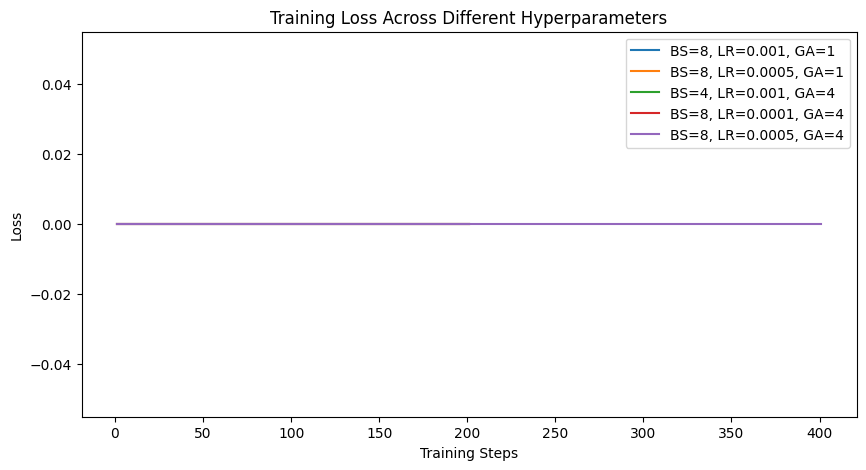

In [29]:
import matplotlib.pyplot as plt


# Plot training loss trends
plt.figure(figsize=(10, 5))
for res in results:
    losses = [x["loss"] for x in res["train_loss"] if "loss" in x]
    steps = list(range(1, len(losses) + 1))
    plt.plot(steps, losses, label=f"BS={res['per_device_train_batch_size']}, LR={res['learning_rate']}, GA={res['gradient_accumulation_steps']}")

plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training Loss Across Different Hyperparameters")
plt.legend()
plt.show()

In [30]:
model.save_pretrained("dpo-gpt2-optimized-model")
tokenizer.save_pretrained("dpo-gpt2-optimized-model")

('dpo-gpt2-optimized-model/tokenizer_config.json',
 'dpo-gpt2-optimized-model/special_tokens_map.json',
 'dpo-gpt2-optimized-model/vocab.json',
 'dpo-gpt2-optimized-model/merges.txt',
 'dpo-gpt2-optimized-model/added_tokens.json',
 'dpo-gpt2-optimized-model/tokenizer.json')

In [31]:
# dpo_trainer = DPOTrainer(
#     model,
#     model_ref,
#     args=training_args,
#     beta=beta,
#     train_dataset=train_dataset,
#     eval_dataset=eval_dataset,
#     tokenizer=tokenizer,
#     max_length=max_length,
#     max_target_length=max_target_length,
#     max_prompt_length=max_prompt_length,
#     generate_during_eval=True,
# )

# dpo_trainer = DPOTrainer(
#     model=model,
#     ref_model=model_ref,
#     args=training_args,
#     processing_class=tokenizer,
#     train_dataset=train_dataset.select(range(5)),
#     eval_dataset=eval_dataset.select(range(5))
# )

# 5. Train

In [32]:
# dpo_trainer.train()

### Upload Model to HuggingFace

In [33]:
!pip install huggingface_hub

In [35]:
from huggingface_hub import login

login()

In [36]:
from huggingface_hub import HfApi

repo_name = "myamjechal/dpo-gpt2-optimized-model"
api = HfApi()

# Create a new model repo if it doesn’t exist
api.create_repo(repo_name, exist_ok=True)

# Push model and tokenizer to Hugging Face Hub
model.push_to_hub(repo_name)
tokenizer.push_to_hub(repo_name)

print(f"Model uploaded! View it here: https://huggingface.co/{repo_name}")

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

Model uploaded! View it here: https://huggingface.co/myamjechal/dpo-gpt2-optimized-model


### Load model from HuggingFace and Test

In [37]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model = AutoModelForCausalLM.from_pretrained("myamjechal/dpo-gpt2-optimized-model")
tokenizer = AutoTokenizer.from_pretrained("myamjechal/dpo-gpt2-optimized-model")

prompt = "What is the best programming language?"
inputs = tokenizer(prompt, return_tensors="pt")
outputs = model.generate(**inputs, max_length=100)
response = tokenizer.decode(outputs[0], skip_special_tokens=True)

print("Model Response:", response)

config.json:   0%|          | 0.00/907 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/507 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.56M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/131 [00:00<?, ?B/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Model Response: What is the best programming language? I don't know," I said. "I don I don I don I don," she said, looking at me with a confused look on her face. I don I don. I don't even think about it. I don I don't even think about it. I don I don I don't even think about it. I don I don I don I don't even think about it. I don I don I don I don I don I don
